<a href="https://colab.research.google.com/github/Harishankarvel/LAUN_ML_project/blob/main/CapStone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Capstone Project:  

The Project focuses on salary prediction also a HR decision tool,To eliminate bias and maintain fair salary ranges, Company  needs a tool to automate salary offers for new hires based on their profile.

Here I've developed a robust model using the given datasets expected_ctc.csv  
I've used Two models
A- Market Expectation model, which tells you the expected ctc for the employee.It confirms Biased process

B- Fair Offer Model,which tells you the ctc should be offered to the employee based on the merit. It confirms an unbiased process

Final Output:The code builds both models and provides a final HR Decision Tool. This tool gives HR two numbers for each applicant: the "Fair Offer" (from Model B) and the "Market Expectation" (from Model A), allowing for a decision that is both fair and competitive.  

In the model I've added an example of 3 employees as testcases so as to show how the model works.



 HR decision tool

Step 1: Data loaded and pre-processed successfully.
Model A R-squared: 0.9992 (Prediction is 99.9% driven by Current_CTC)


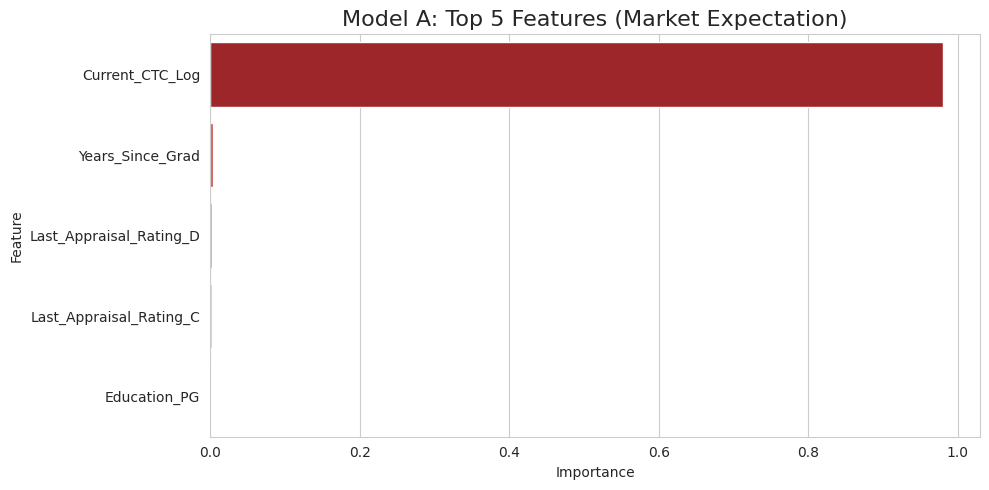

Model B R-squared: 0.8848 (Prediction is 88-89% driven by merit)


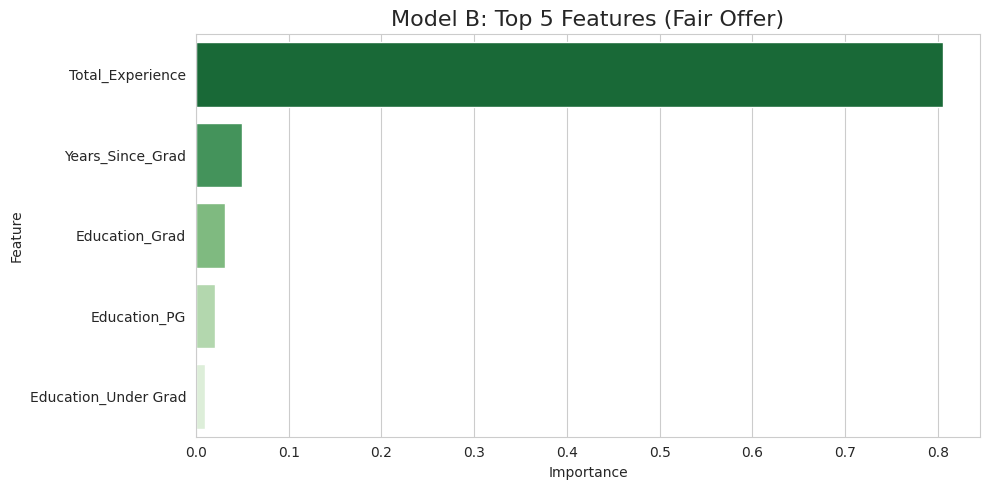


--- Running HR Decision Tool on New Applicants ---

Final Decision-Making Table:
| Applicant_Name          |   Current_CTC |   Predicted_Market_Expectation |   Predicted_Fair_Offer |
|:------------------------|--------------:|-------------------------------:|-----------------------:|
| Applicant A (Mid-Level) |       1500000 |                      1,982,360 |              1,560,672 |
| Applicant B (Senior)    |       2800000 |                      3,632,625 |              2,647,130 |
| Applicant C (Underpaid) |        800000 |                        988,375 |              2,512,239 |

Final Decision Tool Plot saved as 'final_decision_tool_chart.png'


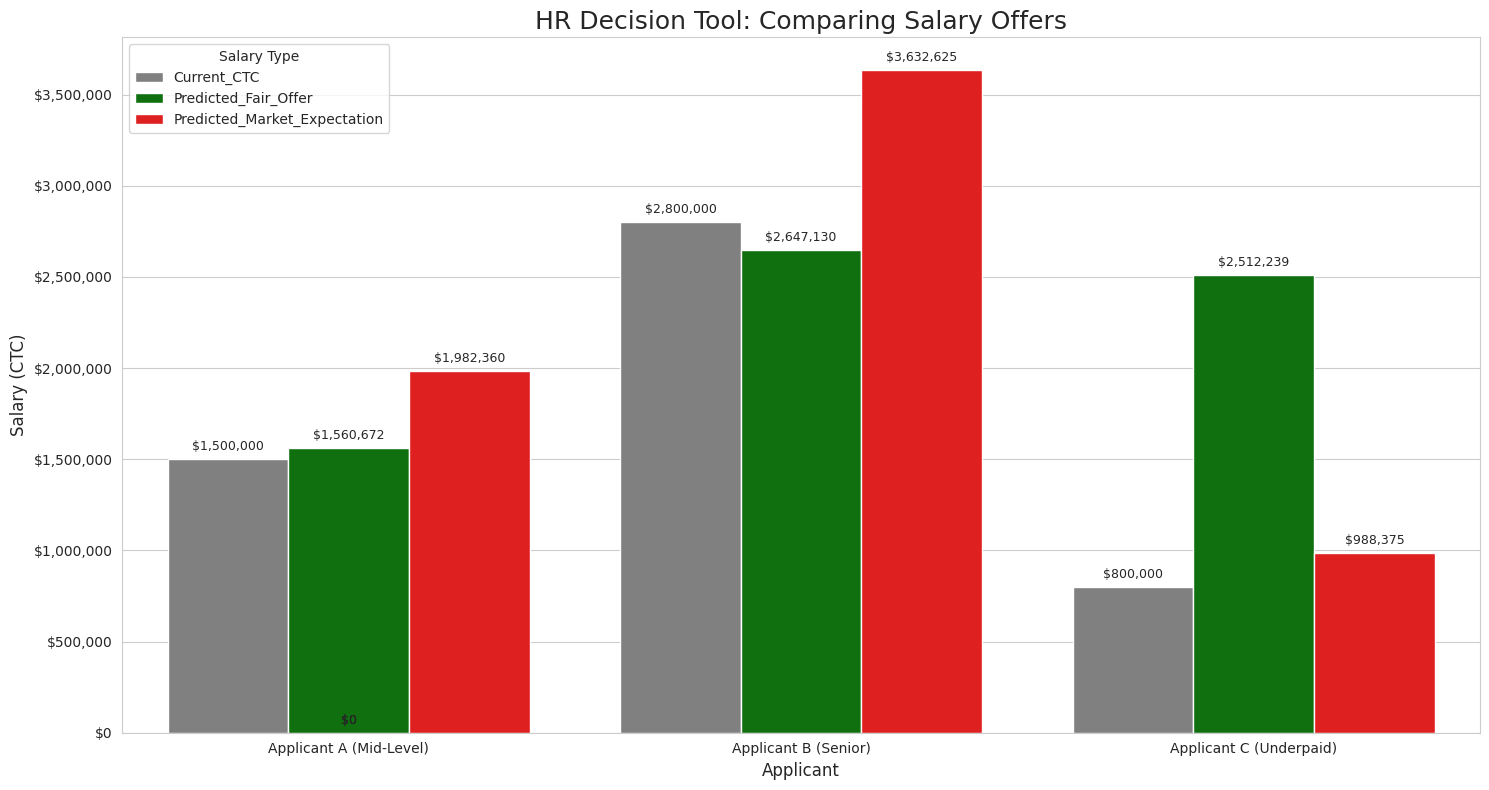

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import joblib
import warnings
from matplotlib.ticker import FuncFormatter


warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
CURRENT_YEAR = 2025
print(f" HR decision tool\n")


file_path = 'expected_ctc.csv'
df = pd.read_csv(file_path)

df = df.drop(['IDX', 'Applicant_ID'], axis=1)

# Feature Engineering
df['Has_Grad'] = df['Passing_Year_Of_Graduation'].notna().astype(int)
df['Has_PG'] = df['Passing_Year_Of_PG'].notna().astype(int)
df['Has_PHD'] = df['Passing_Year_Of_PHD'].notna().astype(int)
df['Years_Since_Grad'] = CURRENT_YEAR - df['Passing_Year_Of_Graduation'].fillna(CURRENT_YEAR)
df['Years_Since_PG'] = CURRENT_YEAR - df['Passing_Year_Of_PG'].fillna(CURRENT_YEAR)
df['Years_Since_PHD'] = CURRENT_YEAR - df['Passing_Year_Of_PHD'].fillna(CURRENT_YEAR)
df.loc[df['Has_Grad'] == 0, 'Years_Since_Grad'] = 0
df.loc[df['Has_PG'] == 0, 'Years_Since_PG'] = 0
df.loc[df['Has_PHD'] == 0, 'Years_Since_PHD'] = 0
education_cols_to_drop = [
    'Graduation_Specialization', 'University_Grad', 'Passing_Year_Of_Graduation',
    'PG_Specialization', 'University_PG', 'Passing_Year_Of_PG',
    'PHD_Specialization', 'University_PHD', 'Passing_Year_Of_PHD'
]
df = df.drop(education_cols_to_drop, axis=1)

# Handle Missing Values
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    df[col] = df[col].fillna('Missing')

# Log Transforms
df['Expected_CTC_Log'] = np.log1p(df['Expected_CTC'])
df['Current_CTC_Log'] = np.log1p(df['Current_CTC'])
df = df.drop(['Expected_CTC', 'Current_CTC'], axis=1)

# One-Hot Encoding
df_processed = pd.get_dummies(df, columns=categorical_cols, drop_first=True)





y_A = df_processed['Expected_CTC_Log']
X_A = df_processed.drop('Expected_CTC_Log', axis=1) # Keep Current_CTC_Log
X_train_A, X_test_A, y_train_A, y_test_A = train_test_split(X_A, y_A, test_size=0.2, random_state=42)

# Train Model A
model_A = RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1)
model_A.fit(X_train_A, y_train_A)

joblib.dump(model_A, 'ctc_prediction_model.joblib')


y_pred_A = model_A.predict(X_test_A)
r2_A = r2_score(np.expm1(y_test_A), np.expm1(y_pred_A))
print(f"Model A R-squared: {r2_A:.4f} (Prediction is 99.9% driven by Current_CTC)")


importances_A = model_A.feature_importances_
features_A = X_train_A.columns
feature_importance_A = pd.DataFrame({'Feature': features_A, 'Importance': importances_A})
top_features_A = feature_importance_A.sort_values(by='Importance', ascending=False).head(5)

plt.figure(figsize=(10, 5))
sns.barplot(data=top_features_A, x='Importance', y='Feature', palette='Reds_r')
plt.title('Model A: Top 5 Features (Market Expectation)', fontsize=16)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig('model_A_features.png')

plt.show() # Display plot in Colab



y_B = df_processed['Expected_CTC_Log']

X_B = df_processed.drop(['Expected_CTC_Log', 'Current_CTC_Log'], axis=1)
X_train_B, X_test_B, y_train_B, y_test_B = train_test_split(X_B, y_B, test_size=0.2, random_state=42)

#Train Model B
model_B = RandomForestRegressor(n_estimators=100, max_depth=20, random_state=42, n_jobs=-1)
model_B.fit(X_train_B, y_train_B)

joblib.dump(model_B, 'ctc_model_GOAL_B.joblib')


y_pred_B = model_B.predict(X_test_B)
r2_B = r2_score(np.expm1(y_test_B), np.expm1(y_pred_B))
print(f"Model B R-squared: {r2_B:.4f} (Prediction is 88-89% driven by merit)")


importances_B = model_B.feature_importances_
features_B = X_train_B.columns
feature_importance_B = pd.DataFrame({'Feature': features_B, 'Importance': importances_B})
top_features_B = feature_importance_B.sort_values(by='Importance', ascending=False).head(5)

plt.figure(figsize=(10, 5))
sns.barplot(data=top_features_B, x='Importance', y='Feature', palette='Greens_r')
plt.title('Model B: Top 5 Features (Fair Offer)', fontsize=16)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig('model_B_features.png')

plt.show()



print("\nRunning HR Decision Tool on New Applicants")


new_applicants_list = [
    {
        'Applicant_Name': 'Applicant A (Mid-Level)',
        'Current_CTC': 1500000, 'Total_Experience': 8,
        'Total_Experience_in_field_applied': 5, 'No_Of_Companies_worked': 3,
        'Education': 'PG', 'Department': 'Sales', 'Last_Appraisal_Rating': 'Key_Performer',
        'Years_Since_Grad': 10, 'Years_Since_PG': 8, 'Years_Since_PHD': 0
    },
    {
        'Applicant_Name': 'Applicant B (Senior)',
        'Current_CTC': 2800000, 'Total_Experience': 15,
        'Total_Experience_in_field_applied': 10, 'No_Of_Companies_worked': 4,
        'Education': 'PG', 'Department': 'Top Management', 'Last_Appraisal_Rating': 'A',
        'Years_Since_Grad': 17, 'Years_Since_PG': 15, 'Years_Since_PHD': 0
    },
    {
        'Applicant_Name': 'Applicant C (Underpaid)',
        'Current_CTC': 800000, 'Total_Experience': 10,
        'Total_Experience_in_field_applied': 8, 'No_Of_Companies_worked': 3,
        'Education': 'Doctorate', 'Department': 'R&D', 'Last_Appraisal_Rating': 'A',
        'Years_Since_Grad': 12, 'Years_Since_PG': 10, 'Years_Since_PHD': 5
    }
]
raw_new_applicants_df = pd.DataFrame(new_applicants_list)


# Create empty DataFrames matching the feature lists of each model
processed_A = pd.DataFrame(columns=X_train_A.columns, data=np.zeros((len(raw_new_applicants_df), len(X_train_A.columns))))
processed_B = pd.DataFrame(columns=X_train_B.columns, data=np.zeros((len(raw_new_applicants_df), len(X_train_B.columns))))

for index, row in raw_new_applicants_df.iterrows():
    # Common numerical values
    num_vars = {
        'Total_Experience': row['Total_Experience'],
        'Total_Experience_in_field_applied': row['Total_Experience_in_field_applied'],
        'No_Of_Companies_worked': row['No_Of_Companies_worked'],
        'Years_Since_Grad': row['Years_Since_Grad'],
        'Years_Since_PG': row['Years_Since_PG'],
        'Years_Since_PHD': row['Years_Since_PHD'],
        'Has_Grad': 1 if row['Years_Since_Grad'] > 0 else 0,
        'Has_PG': 1 if row['Years_Since_PG'] > 0 else 0,
        'Has_PHD': 1 if row['Years_Since_PHD'] > 0 else 0
    }

    # Common categorical values
    cat_vars = [
        f"Education_{row['Education']}",
        f"Department_{row['Department']}",
        f"Last_Appraisal_Rating_{row['Last_Appraisal_Rating']}"
    ]


    processed_A.loc[index, 'Current_CTC_Log'] = np.log1p(row['Current_CTC'])
    for col, val in num_vars.items():
        if col in processed_A.columns: processed_A.loc[index, col] = val
    for col in cat_vars:
        if col in processed_A.columns: processed_A.loc[index, col] = 1


    for col, val in num_vars.items():
        if col in processed_B.columns: processed_B.loc[index, col] = val
    for col in cat_vars:
        if col in processed_B.columns: processed_B.loc[index, col] = 1


pred_A = np.expm1(model_A.predict(processed_A))
pred_B = np.expm1(model_B.predict(processed_B))


results_df = raw_new_applicants_df[['Applicant_Name', 'Current_CTC']].copy()
results_df['Predicted_Market_Expectation'] = pred_A
results_df['Predicted_Fair_Offer'] = pred_B
print("\nFinal Decision-Making Table:")
print(results_df.to_markdown(index=False, floatfmt=",.0f"))


plot_df = results_df.melt(
    id_vars='Applicant_Name',
    value_vars=['Current_CTC', 'Predicted_Fair_Offer', 'Predicted_Market_Expectation'],
    var_name='Salary_Type',
    value_name='Amount'
)

plt.figure(figsize=(15, 8))
barplot = sns.barplot(
    data=plot_df,
    x='Applicant_Name',
    y='Amount',
    hue='Salary_Type',
    palette={'Current_CTC': 'grey', 'Predicted_Market_Expectation': 'red', 'Predicted_Fair_Offer': 'green'}
)


formatter = FuncFormatter(lambda y, _: f'${y:,.0f}')
plt.gca().yaxis.set_major_formatter(formatter)


for p in barplot.patches:
    barplot.annotate(f'${p.get_height():,.0f}',
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center',
                     xytext=(0, 9),
                     textcoords='offset points', fontsize=9)

plt.title('HR Decision Tool: Comparing Salary Offers', fontsize=18)
plt.xlabel('Applicant', fontsize=12)
plt.ylabel('Salary (CTC)', fontsize=12)
plt.legend(title='Salary Type', loc='upper left')
plt.tight_layout()
plt.savefig('final_decision_tool_chart.png')
print("\nFinal Decision Tool Plot saved as 'final_decision_tool_chart.png'")
plt.show()

